# Sentiment Analysis: Using Recurrent Neural Networks

Sentiment Analysis is a form of text classification where we take a text as input and assign a label to it. In this particular application, we want to take a *movie review* as input and analyze the *author's emotion* in that review. More specifically, we want to classify the review as being either **positive** or **negative**.

We will be using *Neural Networks* to build our Sentiment Analysis system. To train our neural network, we will use the [Stanford’s Movies Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/), which contains *25000* training dataset and *25000* test dataset.

This application is a type of Natural Language Processing. **Recurrent Neural Networks** are considered to handle such applications quite well. Note that NLP would be similar to image processing, if it was not for a few differences between text and images. Text inputs are often of variable length (unlike images which can be resized) and the important words can appear anywhere in a sentence. It is quite difficult to build a Neural Network to handle all types of sentences as input in a generic way. RNNs solve this issue by taking one word at a time and trying to remember the important information along the way. Its output at any time is then based on current input and whatever important information it has memorized along the way. **Long Short-Term Memory RNN** is a type of RNN where multiple LSTM cells are used, each capable of memorizing different type of information for some time. Details on LSTM RNN have already been discussed in class lectures.

In the following code, we will use LSTM RNN to build a system capable of sentiment analysis on movie reviews.


## 0. Preparation

Let's start by importing some useful libraries.

In [26]:
# Some python modules:
import time
import collections
import os
import random
import tarfile

# PyTorch modules:
import torch
from torch import nn
import torchtext.vocab as Vocab
import torch.utils.data as Data

We want to use GPU for computations if CUDA is available.

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__, device)

1.2.0.dev20190805 cuda


## 1. Data Loader

### 1.1 Dataset

As mentioned above, we will be using the Stanford's Movies Review Dataset. The dataset is originally compressed to a `.tar.gz` file. We will check if the dataset has already been uncompressed, and if not, uncompress it before we can load it.

In [28]:
# Path that contains all our data:
DATA_ROOT = 'dataset'
# Path that should contain the uncompressed dataset.
DATASET_PATH = os.path.join(DATA_ROOT, 'aclImdb')

# Let's uncompress the dataset if the uncompressed folder is not present.
if not os.path.exists(DATASET_PATH):
    print('Uncompressing dataset...')
    fname = os.path.join(DATA_ROOT, 'aclImdb_v1.tar.gz')
    with tarfile.open(fname, 'r') as f:
        f.extractall(DATA_ROOT)
    print('Done')

The organization of the dataset is as follows:

- There are two folders: `train` for training and `test` for testing, each containing 25K data samples.
- Inside each, there are two subfolders: `pos` for positive reviews and `neg` for negative reviews, each containing equal number of samples.

Let's create a function to load the dataset.

In [29]:
# tqdm to show a nice progress bar.
from tqdm import tqdm

# Load either the training or the test dataset.
def read_imdb(folder='train'):
    # Collect the data samples in a list.
    data = []
    
    # Collect both the positive and the negative samples.
    for label in ['pos', 'neg']:
        # E.g.: positive training samples are in path: `aclImdb/train/pos`.
        folder_name = os.path.join(DATASET_PATH, folder, label)
        
        # Open each file in this folder and read in the review text.
        print('Reading samples from: ', folder_name, flush=True)
        for file in tqdm(os.listdir(folder_name)):
            
            with open(os.path.join(folder_name, file), 'rb') as f:
                # Each review is a unicode text. We will also remove new lines from the reviews.
                review = f.read().decode('utf-8').replace('\n', '')
                
                # Data samples are collected as tuples: (review, label)
                # where label = 1 for positive and 0 for negative.
                data.append((review, 1 if label == 'pos' else 0))
                
    # Before returning, shuffle all the positive and negative samples.
    random.shuffle(data)
    return data

Let's read both the training and the test samples.

In [30]:
train_data = read_imdb('train')
test_data = read_imdb('test')

Reading samples from:  dataset/aclImdb/train/pos


100%|██████████| 12500/12500 [00:00<00:00, 44850.92it/s]

Reading samples from:  dataset/aclImdb/train/neg



100%|██████████| 12500/12500 [00:00<00:00, 44201.86it/s]


Reading samples from:  dataset/aclImdb/test/pos


100%|██████████| 12500/12500 [00:00<00:00, 38439.31it/s]

Reading samples from:  dataset/aclImdb/test/neg



100%|██████████| 12500/12500 [00:00<00:00, 40234.58it/s]


Let's see some training samples.

In [31]:
for x, y in train_data[:5]:
    print('Review: ', x[0:60], '...', 'Label:', y)

Review:  I had recently been watching Johnny Test in an attempt to fi ... Label: 0
Review:  The most embarrassing moment in this film is when Brady Corb ... Label: 0
Review:  First let me preface this post by saying that I am a fan of  ... Label: 0
Review:  The Second Renaissance, part 1 let's us show how the machine ... Label: 0
Review:  This film is exactly what its title describes--an attempt to ... Label: 1


### 1.2 Tokenization

As with all machine learning systems, instead of raw data, we need features to feed into our system. The smallest useful unit in a text such as movie review is the word. So, we will tokenize the text data that we have into sequences of words. For our purpose, we will use a simple split by whitespace technique for tokenization.

In [32]:
# Make sure everything is lowercase and split by whitespace.
def tokenizer(text):
    return [tok.lower() for tok in text.split()]


# A function to tokenize all review samples in our dataset.
def get_tokenized_imdb(data):
    return [tokenizer(review) for review, _ in data]

### 1.3 Vocabulary

A vocabulary is a set of all words present in our training dataset. Instead of just storing the presence of words in a set, we can further store the count of each word in the training set in a hashmap, which we can do with the help of Python's `Counter` class.

In [33]:
def get_vocab_imdb(data):
    # First tokenize the review.
    tokenized_data = get_tokenized_imdb(data)
    # Then collect each token in a Counter hashmap to build a vocabulary.
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    
    # PyTorch Vocab class will be used to represent our vocabulary.
    return Vocab.Vocab(counter, min_freq=5)

# Build vocabulary from the training set.
vocab = get_vocab_imdb(train_data)

print('Number of words in vocabulary:', len(vocab))

Number of words in vocabulary: 46159


### 1.4 Preprocessing

Since we already have vocabulary of all words, for each data sample, we no longer need to store the reviews as sequence of words. Instead, we will store the sequence of word indices to the vocabulary.

Because each review is of different length, it is not possible to combine several of them in a *mini-batch* tensor. So, we will fix the length of each to 500, by truncating longer reviews and adding *&lt;unk&gt;* tokens to shorter reviews.

In [34]:
# Maximum review length:
max_review_length = 500


def truncate_or_pad(x):
    # Note that index [0] is for <unk> token.
    len_x = len(x)
    return x[:max_review_length] if len_x > max_review_length else x + [0] * (max_review_length - len_x)


def preprocess_imdb(data, vocab):
    # First tokenize the data sample.
    tokenized_data = get_tokenized_imdb(data)
    
    # Input feature vector is not the sequence of words but instead the sequence of word indices to the vocabulary.
    features = torch.tensor([
        truncate_or_pad([vocab.stoi[word] for word in words])
        for words in tokenized_data
    ])
    
    labels = torch.tensor([score for _, score in data])
    return features, labels

### 1.5 Data Loader

We will use PyTorch `DataLoader` class to create an iterable data loader, that is capable of loading random samples of data in batches.

We will have three data loaders:

- Training Data Loader: To load the 25K training samples.
- Validation Data Loader: To load the half of the 25K test samples as validation set.
- Test Data Loader: To load the other half of the 25K test samples as test set.

In [35]:
BATCH_SIZE = 64

# Preprocess the training and the test datasets.
train_set = Data.TensorDataset(*preprocess_imdb(train_data, vocab))
# Divide test set into validation and test sets.
half_test_size = int(len(test_data) / 2)
validation_set = Data.TensorDataset(*preprocess_imdb(test_data[:half_test_size], vocab))
test_set = Data.TensorDataset(*preprocess_imdb(test_data[half_test_size:], vocab))

# Create the data loaders.
train_iter = Data.DataLoader(train_set, BATCH_SIZE, shuffle=True, pin_memory=True)
validation_iter = Data.DataLoader(validation_set, BATCH_SIZE, pin_memory=True)
test_iter = Data.DataLoader(test_set, BATCH_SIZE, pin_memory=True)

To check that the data loader works, let's iterate once with the training data loader and check the data size.

In [36]:
for X, y in train_iter:
    print('X:', X.shape, 'y:', y.shape)
    break
    
print('Number of batches:', len(train_iter))

X: torch.Size([64, 500]) y: torch.Size([64])
Number of batches: 391


## 2. Building the Neural Network


### 2.1 Architecture

The architecture of our Neural Network is as follows:

<img src="architecture.jpeg" width="720px">

1. **Embedding**

We will be using *GloVe* word embedding to convert the input words into feature vectors. Details about this approach is discussed in the accompanying slides. Below, we have just created a dummy embedding layer using PyTorch but we will see in the next section how we can initialize it with GloVe vocabulary. In our case, the size of the feature vectors will be 100.

2. **LSTM Layers**

We will use *Bidirectional LSTM* consisting of 2 layers and 100 hidden states.

3. **Fully Connected Layer**

We will then take the hidden states of both the initial and the final timesteps of the Bidirectional LSTM and connect it to a fully-connected linear network of neurons. The output of this layer will be two scalars, one representing the *negative* and the another representing the *positive* review.

4. **Output and Error Function**

The output layer consists of two neurons of the previous fully connected layer. The classification will be *positive* or *negative* based on whichever neuron has larger final value. To get the probability of the review to be in either of the class, we can use *softmax* function, if we want. To train the network, we will need some loss function. In our case, we will use *Cross Entropy based on Softmax Output* as the loss (error) function.

In [37]:
class BiRNN(nn.Module):
    def __init__(self, vocab, embed_size=100, num_hiddens=100, num_layers=2):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(len(vocab), embed_size)
        
        # Bidirectional LSTM layers
        self.encoder = nn.LSTM(input_size=embed_size, hidden_size=num_hiddens, num_layers=num_layers, bidirectional=True)
        
        # Fully connected layer
        self.decoder = nn.Linear(4*num_hiddens, 2)
        
    def forward(self, inputs):
        # Embed words into feature vectors:
        embeddings = self.embedding(inputs.permute(1, 0))
        
        # Encode reviews using Bidirectional LSTM into hidden codes.
        # Note that we will use the hidden states of both the first and the last timestep as the hidden codes.
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), -1)
        
        # Use the fully connected layer to classify the reivew based on the encoding.
        return self.decoder(encoding)

Let's create the actual neural network using the above architecture.

In [38]:
embed_size = 100
num_hiddens = 100
num_layers = 2

net = BiRNN(vocab, embed_size, num_hiddens, num_layers)

### 2.2 GloVe Word Embedding

Since we will be using [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) to embed our words into feature vectors, we need to initialize the embedding layer of our neural network using GloVe word vectors. To do so, we need the mapping of each word to their corresponding vectors. However, our training set is too small to generate the word vectors using GloVe. We will instead use a pre-trained GloVe vocabulary from Stanford's 6B dataset.

In [39]:
glove_vocab = Vocab.GloVe(name='6B', dim=100, cache=os.path.join(DATA_ROOT, "glove"))

Let's map each word in our vocabulary to the index of the above pretrained GloVe vocabulary. For words that do not exist in the pretrained set, we will map them to *&lt;unk&gt;* (index = 0) token. Then, we will initialize the embedding layer of our neural network with these GloVe word vectors.

In [40]:
def load_pretrained_embedding(words, pretrained_vocab):
    embed = torch.zeros(len(words), pretrained_vocab.vectors[0].shape[0])
    
    # Let's keep track of the number of out of vocabulary words.
    oov_count = 0
    
    for i, word in enumerate(words):
        try:
            idx = pretrained_vocab.stoi[word]
            embed[i, :] = pretrained_vocab.vectors[idx]
        except KeyError:
            oov_count+= 1
    
    print('There are {} out of vocabulary words.'.format(oov_count))
    return embed


# Initialize the weights of the embedding layer so that it can map word into corresponding GloVe word vector.
net.embedding.weight.data.copy_(load_pretrained_embedding(vocab.itos, glove_vocab))
# We won't be training the embedding layer.
net.embedding.weight.required_gra = False

There are 21203 out of vocabulary words.


# 2.3 Training

Here are our training parameters:

In [41]:
# Learning Rate:
lr = 0.01

# Number of training epochs:
epochs = 10

# Optimization algorithm:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)

# Loss function:
loss = nn.CrossEntropyLoss()

**Accuracy** of a classification is the percentage of correctly classified samples.

In [42]:
def calc_accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).sum().cpu().item()


def eval_dataset(data_iter, net):
    # accumulate accuracy for each sample and the number of samples.
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y_hat = net(X.to(device))
        acc_sum += calc_accuracy(y_hat, y.to(device))
        n += y.shape[0]
    
    return acc_sum / n
        

Training is done using **back-propagation** of the error gradient. As mentioned previously, the error here is the Cross-Entropy error based on softmax output.

During training, we also want to use our validation set to evaluate the network and make sure that the network does not overfit the training set. We do so by plotting both the training and the validation error and finding the point where we get the minimum validation error (or maximum validation accuracy).

In [43]:
net.to(device)

# State of the network when we get the least validation error.
best_state = {
    'epoch': None,
    'accuracy': None,
    'model_state': None,
    'optimizer_state': None,
}

# Function to record the network parameters.
def record_best_state(epoch, new_accuracy):
    best_accuracy = best_state['accuracy']
    if best_accuracy is None or new_accuracy > best_accuracy:
        best_state['epoch'] = epoch
        best_state['accuracy'] = new_accuracy
        best_state['model_state'] = net.state_dict()
        best_state['optimizer_state'] = optimizer.state_dict()
        
        
# Function to restore the network parameters.
def restore_best_state():
    net.load_state_dict(best_state['model_state'])
    optimizer.load_state_dict(best_state['optimizer_state'])

    
# Record the training and validation accuracies for plotting.
train_accs = []
valid_accs = []

batch_count = 0
for epoch in range(epochs):
    train_l_sum = 0.0
    train_acc_sum = 0.0
    n = 0
    start = time.time()
    
    for X, y in train_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        train_l_sum += l.cpu().item()
        train_acc_sum += calc_accuracy(y_hat, y)
        
        n += y.shape[0]
        batch_count += 1
    
    valid_acc = eval_dataset(validation_iter, net)
    train_acc = train_acc_sum / n
    
    # Let's keep track of the best validation accuracy:
    record_best_state(epoch, valid_acc)
    
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    print(f'Epoch: {epoch + 1}, '
          f'loss: {train_l_sum / batch_count:.4f}, '
          f'training accuracy: {train_acc:.3f}, '
          f'valid accuracy: {valid_acc:.3f}, '
          f'time: {time.time() - start:.1f} sec')

Epoch: 1, loss: 0.4378, training accuracy: 0.792, valid accuracy: 0.864, time: 74.2 sec
Epoch: 2, loss: 0.0876, training accuracy: 0.941, valid accuracy: 0.845, time: 73.5 sec
Epoch: 3, loss: 0.0227, training accuracy: 0.980, valid accuracy: 0.853, time: 72.6 sec
Epoch: 4, loss: 0.0096, training accuracy: 0.989, valid accuracy: 0.846, time: 72.8 sec
Epoch: 5, loss: 0.0048, training accuracy: 0.994, valid accuracy: 0.833, time: 72.3 sec
Epoch: 6, loss: 0.0035, training accuracy: 0.994, valid accuracy: 0.818, time: 72.4 sec
Epoch: 7, loss: 0.0039, training accuracy: 0.991, valid accuracy: 0.833, time: 73.2 sec
Epoch: 8, loss: 0.0027, training accuracy: 0.994, valid accuracy: 0.829, time: 73.2 sec
Epoch: 9, loss: 0.0014, training accuracy: 0.997, valid accuracy: 0.831, time: 74.2 sec
Epoch: 10, loss: 0.0010, training accuracy: 0.997, valid accuracy: 0.830, time: 74.7 sec


We can visualize the trend of training and validation accuracies as follows:

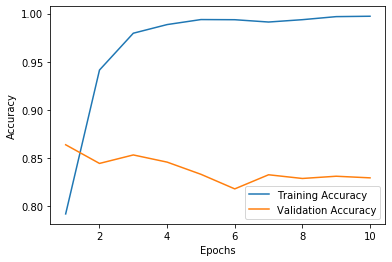

In [53]:
import matplotlib.pyplot as plt

xaxis = range(1, epochs+1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(xaxis, train_accs, label='Training Accuracy')
plt.plot(xaxis, valid_accs, label='Validation Accuracy')
plt.legend()
plt.show()

The validation accuracy is clearly not the highest at the final epoch. So, we will restore the network parameters to the epoch where we had the highest validation accuracy.

In [46]:
print('Best epoch:', best_state['epoch'] + 1)
restore_best_state()
print('Network restored.')

Best epoch: 1
Network restored.


# 2.4 Test Results

First, let's see how well our network does in predicting sentiment of new movie reviews. We will create a function for prediction.

In [47]:
def predict_sentiment(sentence):
    tokens = tokenizer(sentence)
    features = torch.tensor([vocab.stoi[word] for word in tokens], device=device)
    label = torch.argmax(net(features.view((1, -1))), dim=1)
    
    return 'positive' if label.item() == 1 else 'negative'

In [48]:
predict_sentiment('This movie is so great')

'positive'

In [49]:
predict_sentiment('I do not really like this movie')

'negative'

Looks pretty good.

Let us calculate the final accuracy of the network using the test set.

In [50]:
test_acc = eval_dataset(test_iter, net)
print(f'Accuracy of the network over test set: {test_acc * 100:.2f}%')

Accuracy of the network over test set: 82.42%
